# Animorphs Authenticity, Notebook 01
#### Ethan Henley

## Problem Statement:

When authorship is uncertain, specific word choices and text patterns can be used to determine whether or not a text was written by a certain author. I wish to develop a model for reading in two large corpuses, one authentically written by an author and one ghostwritten, and predicting which corpus a text belongs to. 

One recent [paper](https://arxiv.org/abs/1911.05652) by Petr Plecháč analyzed the authorship of specific subsections of the play Henry VIII to determine where either of the authors suspected of involvement contributed. Its methodology is not directly applicable to non-poetic texts, as it greatly involves cadence and meter in its modeling process. I wish to perform similar analysis on another, non-metered corpus to generalize author authenticity analysis.

For this analysis, I will use the Animorphs series, 54 children's science-fiction/fantasy books of which about half were ghostwritten, as my corpus. The model will be specific to this collection of books, but the strategies implemented should be relevant for other authorship analyses.

I will vectorize words in individual chapters of Animorphs books using Word2Vec against the corpus as a whole, and then take each chapter's average vector, reduce its dimensionality using t-distributed Stochastic Neighbor Embedding, and then use a Simple Vector Machine classifier to delineate author authenticity. The classifier will be scored on accuracy, as either type of misattribution is undesirable.

## Collection & EDA Process:

The corpus was gathered from [Richard's Animorphs Forum](https://animorphsforum.com/ebooks/), where the Animorphs series of books is hosted for free access with the blessing of the creator. I use the main series only. Authenicity was taken from [this Wikipedia section](https://en.wikipedia.org/wiki/Animorphs#Ghostwriters). Books were read chapter by chapter using `ebooklib` and `BeautifulSoup`. Chapters were processed, proper nouns and stopwords were removed, and then words were tokenized to develop a corpus. A first quick look showed what words were most common across the corpus.

In [17]:
import pandas as pd

import re
from nltk.corpus import stopwords

import ebooklib
from ebooklib import epub

from bs4 import BeautifulSoup

import matplotlib.pyplot as plt

## Data Collection & Initial Cleaning

Read out all the books' chapters into a two-layer dictionary. 

Books were downloaded as `.epub` files from [Richard's Animorphs Forum](https://animorphsforum.com/ebooks/).

In [2]:
books_dict = {}

for book_no in range(1,55): # for each book in main series
    
    no_string = str(book_no).zfill(2) # format leading 0
    book = epub.read_epub(f'../books/{no_string}.epub') # read in book
    
    # get chapters and chapter-like things; index no.s may not correspond
    # to actual chapter no.s
    chapters = [c for c in book.get_items_of_type(ebooklib.ITEM_DOCUMENT)]

    chapter_dict = {}
    for chapter_no, chapter in enumerate(chapters): # for chapter in book
        
        # list of paragraphs as strings
        paragraphs = [b.text for b in 
                      BeautifulSoup(chapter.content, 'xml'
                                   ).find_all('p')][1:] # p0 always blank
        
        chapter_dict[chapter_no] = '\n'.join(paragraphs) # list as lines
        
    books_dict[book_no] = chapter_dict

Convert dictionary into df of chapters.

In [3]:
df_list = []

for k,v in books_dict.items():
    for vk,vv in v.items():
        df = pd.DataFrame({'book':k,
                           'chapter':vk,
                           'text':vv}, index=[0])
        df_list.append(df)

books_df = pd.concat(df_list).reset_index().drop(columns='index') # combine
books_df = books_df[books_df['text'] != ''] # clean 'empty' chapters

In [4]:
books_df

,book,chapter,text
1,1,1,"My name is Jake. That's my first name, obvious..."
2,1,2,"""A flying saucer?"" Marco said. He did laugh. T..."
3,1,3,<They have come to destroy you.>\nIt was stran...
4,1,4,<Yeerks!>\nThe twin red lights slowed. They tu...
5,1,5,"The Hork-Bajir pointed his gun, or whatever it..."
...,...,...,...
1520,54,18,The world's smartest mouse wiggled his nose at...
1521,54,19,I had nine million four hundred and thirty-two...
1522,54,20,"We drove through the desert night, silent most..."
1523,54,21,The Rachel was fast.\nWe blew through normal s...


Add authenticity columns; 1 denotes a book written by Applegate, 0 denotes a book ghostwritten.

In [5]:
auths = [i for i in range(1,25)] + [26, 32, 53, 54]
books_df['authenticity'] = books_df['book'].map(lambda b: int(b in auths))

books_df.head()

,book,chapter,text,authenticity
1,1,1,"My name is Jake. That's my first name, obvious...",1
2,1,2,"""A flying saucer?"" Marco said. He did laugh. T...",1
3,1,3,<They have come to destroy you.>\nIt was stran...,1
4,1,4,<Yeerks!>\nThe twin red lights slowed. They tu...,1
5,1,5,"The Hork-Bajir pointed his gun, or whatever it...",1


Save df to csv.

In [6]:
books_df.to_csv('../data/animorphs.csv')

## EDA & Continued Cleaning

For Word2Vec analysis, will need to aggressively remove stopwords, including common proper nouns that may show up different amounts throughout the books. We will also need to remove all non-word elements, such as punctuation.

We remove proper nouns primarily to avoid 'cheating'; characters appear more often in some books than others, and this may inappropriately 'help' the model isolate individual books without using information related to authorship.

In [7]:
# frequent character names and other proper nouns
# manually collected from animorphs.fandom.com
pnouns = ['jake','rachel','marco','james','craig','erica','tobias',
          'cassie','aximili','esgarrouth','isthill',
          'aximiliesgarrouthisthill','david','melissa','chapman',
          'collette','kelly','timmy','julio','liam','tricia','jessie',
          'judy','ray', 'ax','hork','bajir','visser','andalite',
          'yeerk','yeerks']

In [8]:
# set up stopwords, including proper nouns

stops = stopwords.words('english') + pnouns

# clean stops to same format as other text

stops = re.sub(r'[^a-zA-Z ]','',' '.join(stops)).lower().split()

In [9]:
def clean_chapter(chapter, stops=stops):
    # regex non-letters, lowercase, tokenize
    chapter = chapter.replace('-',' ')
    chapter = re.sub(r'[^a-zA-Z ]','',chapter).lower().split()
    chapter = [w for w in chapter if w not in stops] # remove stopwords
    return chapter

Check that the cleaning makes sense.

In [10]:
# test-visualize the start of a single chapter
books_df.loc[1,'text'][:198]

"My name is Jake. That's my first name, obviously. I can't tell you my last name. It would be too dangerous. The Controllers are everywhere. Everywhere. And if they knew my full name, they could find"

In [11]:
# test-visualize the same text, preprocessed
clean_chapter(books_df.loc[1,'text'][:198])

['name',
 'thats',
 'first',
 'name',
 'obviously',
 'cant',
 'tell',
 'last',
 'name',
 'would',
 'dangerous',
 'controllers',
 'everywhere',
 'everywhere',
 'knew',
 'full',
 'name',
 'could',
 'find']

Cleaned text makes sense.

Establish entire corpus.

In [12]:
corpus = []
for chapter in books_df['text']:
    corpus += clean_chapter(chapter)

Look at frequently occurring words.

In [15]:
top_freqs={w:corpus.count(w) for w in set(corpus) if corpus.count(w)>2000}

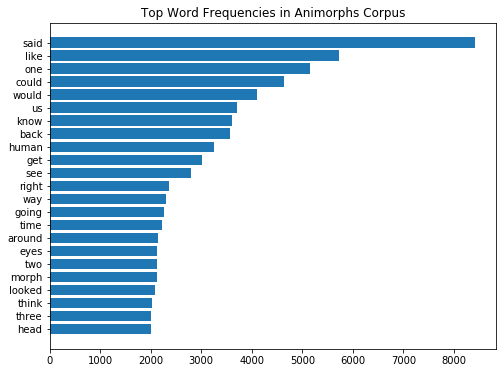

In [19]:
top_freqs = {k:v for k,v in 
             sorted(top_freqs.items(), key=(lambda kv:kv[1]))} # sort dict

plt.figure(figsize=(8,6))

# super elegant dict bar adapted from ImportanceOfBeingErnest at
# stackoverflow.com/questions/16010869
plt.barh(*zip(*top_freqs.items()))

plt.title('Top Word Frequencies in Animorphs Corpus');